(tensor-network-design)=

# Design

The section contains some notes on the design of quimb's tensor network
functionality that should be helpful for a) understanding how certain functions
work better, and b) implementing more advanced functions or contributing to quimb.

In [1]:
%config InlineBackend.figure_formats = ['svg']

# the main tensor and tensor network functionality
import quimb.tensor as qtn

# backend agnostic array functions
from autoray import do

## `Tensor`

The {class}`~quimb.tensor.tensor_core.Tensor` object, unsurprisingly,
is the core object in `quimb.tensor`. It has three main attributes.

### `Tensor.data`

This is **any n-dimensional array looking object** (i.e. something with a
`.shape` attribute). Whenever array functions are performed on a
tensors `.data`, [autoray](https://github.com/jcmgray/autoray)
is used to dispatch to the correct backend functions, so `quimb`
itself does no explicit conversion of array backends.

In [2]:
data = do('random.uniform', size=(3, 4, 5), like='cupy')

Having said that, if the supplied `data` has no `.shape` attribute
{func}`numpy.asarray` will be called on it.

### `Tensor.inds`

This is an **ordered tuple of index names** - one for each of the dimensions
of `.data`. Functions that would normally require 'axes' to be specified
instead can just use names, and these are propagated through all operations.
For example, operations such as transposing the underyling array can just
be done via reordering the `inds` of the tensor.

In [3]:
inds = ('a', 'b', 'c')

Moreover, the names of indices explicitly define the geometry of bonds
(edges) in tensor networks at this local tensor level - there are no extra
'index' objects and this information is thus completely local.

### `Tensor.tags`

These are an **ordered set** (quimb has a quick `dict` based implementation
\- {class}`~quimb.utils.oset`)  of **an arbitrary number of extra
identifiers** for the tensor. The main use of these is that *within a
tensor network* you can use any number of simultenous labelling schemes to
identify your tensors with. You probably don't need to use any if just using
raw tensors.

In [4]:
tags = qtn.oset(['hello', 'world'])

:::{note}
{class}`~quimb.utils.oset` is used in many places across `quimb.tensor`
**in order to make all operations deterministic**, unlike {class}`set`. You can
supply any (ideally itself ordered) iterable to `tags` and it will
be converted for you.
:::

## Creating & Contracting Tensors

We can use our `data`, `inds` and (optional) `tags` to create a tensor:

In [5]:
T = qtn.Tensor(data=data, inds=inds, tags=tags)
T

Tensor(shape=(3, 4, 5), inds=('a', 'b', 'c'), tags=oset(['hello', 'world']))

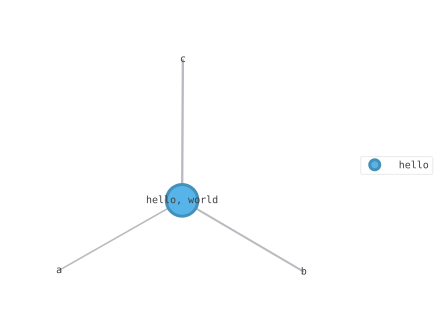

In [6]:
T.draw(color='hello')

Just on their own (i.e. not within a tensor network) just the labelled dimension
aspect of tensors is already very convenient.
Here's {meth}`~quimb.tensor.tensor_core.Tensor.fuse`,
for example, which would usually require some non-trivial combination of axis finding,
permuting, reshaping etc:

In [7]:
T1 = T.fuse({'ac': ('a', 'c')})
T1

Tensor(shape=(15, 4), inds=('ac', 'b'), tags=oset(['hello', 'world']))

More importantly, the indices of a tensor also exactly define the subscripts
as would appear in a
[implicit Einstein summation](https://en.wikipedia.org/wiki/Einstein_notation),
such that if we create the following tensor:

In [8]:
T2 = qtn.Tensor(
    # use whatever backend function T1's data is using
    data=do('random.uniform', size=(6, 15), like=T1.data),
    # 'd' is new, 'ac' is shared with T1
    inds=['d', 'ac'],
    tags=['T2'])
T2

Tensor(shape=(6, 15), inds=('d', 'ac'), tags=oset(['T2']))

The fact that both tensors have a `'ac'` index means that when combined
the two corresponding dimensions are either implicitly or explicitly summed
over (contracted) like so:

```{math}
T_{3}[b, d] = \sum_{ac} T_1[ac, b] T_2[d, ac]
```

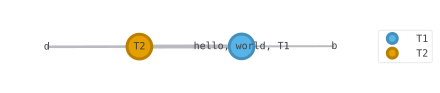

In [9]:
T1.add_tag('T1')
(T1 | T2).draw(color=['T1', 'T2'])

In [10]:
T3 = T1 @ T2  
# == qtn.tensor_contract(T1, T2)
# == T1.contract(T2)
T3

Tensor(shape=(4, 6), inds=('b', 'd'), tags=oset(['hello', 'world', 'T1', 'T2']))

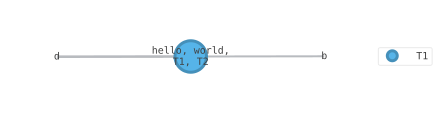

In [11]:
T3.draw(color=['T1'])

The `@` operator eagerly contracts two tensors according to this
summation (via [`qtn.tensor_contract`](quimb.tensor.tensor_core.tensor_contract)),
thereby removing the `'ac'` index. As you can see, contracting
two tensors also merges their tags.

:::{hint}
In `quimb`, **the names of the indices entirely define the geometry
of the tensor network**. If you want two tensor dimensions to be contracted
just name them the same thing. Alternatively use
[`qtn.connect`](quimb.tensor.tensor_core.connect) to name them for you. The actual
name is not so important, in as much as its unique and shared, you can
generate new names automatically using
[`qtn.rand_uuid`](quimb.tensor.tensor_core.rand_uuid).

The fact that the specific name of internal indices has no effect on the
overall oject represented is made use of by
[`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork) -
see - {ref}`indexmangling`.
:::

## Copying & Modifying Tensors

You can copy a tensor with [`Tensor.copy`](quimb.tensor.tensor_core.Tensor.copy), (note
by default this **doesn't** copy the `.data` - see below), and update it with
[`Tensor.modify`](quimb.tensor.tensor_core.Tensor.modify). Routing all changes to tensors
through [`Tensor.modify`](quimb.tensor.tensor_core.Tensor.modify) allows various checks, and
for tensors to automatically inform any tensor networks they belong to, for example.

An example of a typical tensor method that demonstrates the above is the following:


In [12]:
def sum_reduce(self, ind, inplace=False):
    """Sum the array axis corresponding to ``ind``.
    """
    # easily enables copy vs inplace version
    t = self if inplace else self.copy()
    
    # get the axis `ind` corresponds to
    axis = t.inds.index(ind)
    
    # use autoray.do to be backend agnostic
    new_data = do('sum', t.data, axis=axis)
    new_inds = t.inds[:axis] + t.inds[axis + 1:]
    
    # update tensor using modify
    t.modify(data=new_data, inds=new_inds)
    
    # return `t` even if inplace to allow method chaining
    return t

sum_reduce(T1, 'b')

Tensor(shape=(15,), inds=('ac',), tags=oset(['hello', 'world', 'T1']))

A convention that `quimb` adopts is for many common methods to have inplace
versions specifically named with a trailing underscore, like:

- [`Tensor.sum_reduce`](quimb.tensor.tensor_core.Tensor.sum_reduce)
- [`Tensor.sum_reduce_`](quimb.tensor.tensor_core.Tensor.sum_reduce_)

:::{warning}
All array functions in `quimb` as assumed to be **pure**, i.e. return
a new array and not modify the original.
This allows tensor copies by default *to not copy their* `.data`, which saves
memory and is more efficient with backends that e.g. construct an explicit
computational graph. You should only inplace modify the actual arrays if
you know what you are doing, or after calling `.copy(deep=True)` first.
:::

## `TensorNetwork`

As described above, there is already an implicit tensor network
geometry introduced by simply matching up tensor index names -
and indeed you could just keep track of the tensors yourself.

However, its generally useful to collect tensors into a
{class}`~quimb.tensor.tensor_core.TensorNetwork` object,
which enables $\mathscr{O}(1)$ access to any tensors based on
their `inds` or `tags`, as well as encapsulating all sorts of
functionality the depends on the network relations of the tensors.

In [13]:
ta = qtn.rand_tensor((2, 3, 3), ['a', 'x', 'y'], tags='A')
tb = qtn.rand_tensor((2, 3, 3), ['b', 'y', 'z'], tags='B')
tc = qtn.rand_tensor((2, 3, 3), ['c', 'z', 'x'], tags='C')

tn = qtn.TensorNetwork([ta, tb, tc])
tn

<TensorNetwork(tensors=3, indices=6)>

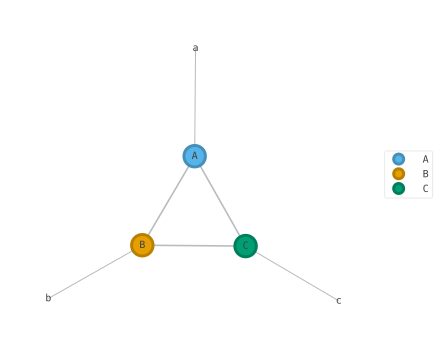

In [14]:
tn.draw(color=['A', 'B', 'C'])

:::{note}
By default TNs take copies of the input tensors,
(but again, not the actual data array).
This can be turned off and it is
possible e.g. to create multiple TNs that view
the same tensors - see {ref}`virtualtns`.
:::

Tensor networks also have three key attributes...

### `TensorNetwork.tensor_map`

The key storage of a {class}`~quimb.tensor.tensor_core.TensorNetwork`
is the `tensor_map` attribute. This is a mapping of 'tids' - unique
integers reprensenting nodes in the network - to the actual tensor at
that node, which need not be unique.

In [15]:
tn.tensor_map

{0: Tensor(shape=(2, 3, 3), inds=('a', 'x', 'y'), tags=oset(['A'])),
 1: Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B'])),
 2: Tensor(shape=(2, 3, 3), inds=('c', 'z', 'x'), tags=oset(['C']))}

This means that the same tensor can be in the same or different tensor networks multiple times.

:::{hint}
`'tids'` are essentially vertex labels in the (hyper) graph of the TN.
:::

### `TensorNetwork.ind_map`

This is a mapping of every index in the tensor network to the ordered
set of 'tids' of the tensors which have that index.

In [16]:
tn.ind_map

{'a': oset([0]),
 'x': oset([0, 2]),
 'y': oset([0, 1]),
 'b': oset([1]),
 'z': oset([1, 2]),
 'c': oset([2])}

For example if we wanted all tensors with the ``'z'`` index, we could call:

In [17]:
[tn.tensor_map[tid] for tid in tn.ind_map['z']]

[Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B'])),
 Tensor(shape=(2, 3, 3), inds=('c', 'z', 'x'), tags=oset(['C']))]

:::{hint}
`ind_map[ix]` is essentially the set of (hyper) graph vertices the
(hyper) edge `ix` is incident to.
:::

### `TensorNetwork.tag_map`

Similarly, this is a mapping of every tag in the tensor network to the ordered
set of 'tids' of the tensors which have that tag.

In [18]:
tn.tag_map

{'A': oset([0]), 'B': oset([1]), 'C': oset([2])}

If we wanted all tensors tagged with ``'B'`` we could call:

In [19]:
[tn.tensor_map[tid] for tid in tn.tag_map['B']]

[Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B']))]

## Selecting Tensors Based on Tags - the `which` kwarg

`tags` are the main high level method for labelling and
accessing tensors. Many functions which take a `tags` and
`which` arg, e.g. [`TensorNetwork.select`](quimb.tensor.tensor_core.TensorNetwork.select)
internally call
{meth}`~quimb.tensor.tensor_core.TensorNetwork._get_tids_from_tags`.
When supplied to this, the `which` kwarg takes four options:

- `'all'` return tids for tensors which match **all** the tags
- `'!all'` return tids for tensors which *don't* match **all** the tags
- `'any'` return tids for tensors which match **any** of the tags
- `'!any'` return tids for tensors which *don't* match **any** of the tags

In [20]:
tn._get_tids_from_tags(['A', 'B'], which='any')

oset([0, 1])

## Copying & Modifying Tensor Networks

Tensor networks also have a
[`TensorNetwork.copy`](quimb.tensor.tensor_core.TensorNetwork.copy) method which
is used heavily. As with creation, by default this copies both
the TN and the tensors it contains (but again, not their data).

In terms of modifying tensor networks, `quimb` takes the general
approach that you **directly modify tensors in a TN,
which then automatically tell the TN, and possibly other
TNs, about any relevant changes**.

In [21]:
# get the tensor identified by tag 'A'
t = tn['A']  

# inplace rename an index
t.reindex_({'a': 'b'})

# changes are automatically reflected in ``tn``
tn.ind_map

{'x': oset([0, 2]),
 'y': oset([0, 1]),
 'b': oset([1, 0]),
 'z': oset([1, 2]),
 'c': oset([2])}

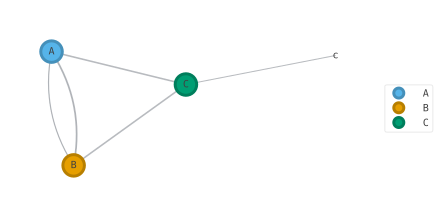

In [22]:
# 'b' should now be traced over
tn.draw(color=['A', 'B', 'C'])

In [23]:
def tanh_neighbors(self, tag, inplace=False):
    """Example function that demonstrates the anatomy of a 
    typical tensor network  method, using ``tensor_map``, 
    ``ind_map``, ``tag_map``, and ``modify``.
    """
    # easily handle both copy and non copy methods
    tn = self if inplace else self.copy()
    
    # get the unique tensor identifiers from our tag
    tids = tn.tag_map[tag]
    
    # collect neighbors in here -> oset for determinism
    neighbors = qtn.oset()
    
    # for every tid in our tagged region
    for tid in tids:
        
        # get the tensor
        t = tn.tensor_map[tid]
        
        # for each of its inds
        for ix in t.inds:
            
            # add all tensors with that index to neighbors
            neighbors |= tn.ind_map[ix]
            
    # now apply tanh to our expanded region
    for tid in neighbors:
        # always use modify and autoray to update tensors
        t = tn.tensor_map[tid]
        t.modify(data=do('tanh', t.data))
    
    # return tn even if self (i.e. inplace) for method chaining
    return tn

qtn.TensorNetwork.tanh_neighbors = tanh_neighbors

# create trailing underscore inplace version
import functools
qtn.TensorNetwork.tanh_neighbors_ =  \
    functools.partialmethod(tanh_neighbors, inplace=True)

In use:

In [24]:
tn['A'].data.item(0)

0.29875539039274684

In [25]:
tn.tanh_neighbors_('B')

<TensorNetwork(tensors=3, indices=5)>

In [26]:
# since A is connected to B, its data should have been tanh'd
tn['A'].data.item(0)

0.29017321167219656

## Combining TNs

(indexmangling)=

### Index Mangling

While it is very convenient generally to have the tensor network geometry
defined 'locally' just by `Tensor.inds`, **there is one main drawback**.

1. Imagine we have two tensor networks, `tn1` and `tn2`,
   both with the same outer indices - e.g. `('k0', 'k1', 'k2', 'k3', ...).
2. When we combine these these networks we expect the new TN to automatically
   represent the overlap of these networks - i.e. with the `'k{}'` indices
   contracted.
3. **However**, if `tn2` has the same internal indices as `tn1` (e.g. it
   actually is `tn1`, or is a copy of or is derived from `tn1` etc.),
   then these indices will now clash and appear four times in the new TN.

The solution `quimb` adopts is that when you combine two or more tensor
networks, **inner indices in the latter will be mangled** - 'inner' being defined
as those appearing $\geq 2$ times. This is fairly natural since renaming
internal indices has no effect on the overall TN object represented, but it does
mean **you should only rely on outer index names being preserved**.

:::{hint}
In general in `quimb`, you should keep track of the external indices of
a TN and the tags describing the internal tensor structure. If and when you
need explicit index names you can retrieve them from the tensors with, e.g.:

- [`qtn.bonds`](quimb.tensor.tensor_core.bonds)
- [`qtn.group_inds`](quimb.tensor.tensor_core.group_inds)
- [`Tensor.filter_bonds`](quimb.tensor.tensor_core.Tensor.filter_bonds)
:::

(virtualtns)=

### Virtual TNs

When you create a {class}`~quimb.tensor.tensor_core.TensorNetwork`, from some
collection of tensors and/or other tensor networks, the tensors are added via:

- [`TensorNetwork.add_tensor`](quimb.tensor.tensor_core.TensorNetwork.add_tensor)
- [`TensorNetwork.add_tensor_network`](quimb.tensor.tensor_core.TensorNetwork.add_tensor_network)

By default the tensors (**but not the data - see above**), are copied, so that
they only appear in the new TN. This behavior corresponds to the
`virtual=False` option and overloaded operators:

- `&`
- `&=`

used to combine tensors and tensor networks.

In [27]:
tx = qtn.rand_tensor([3, 4], ['a', 'b'], tags='X')
ty = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Y')

tn = tx & ty
# == qtn.TensorNetwork([tx, ty], virtual=False)

tx is tn['X']

False

Any changes to `tx` *won't* affect `tn`.

If you want to tensor networks to 'view' existing tensors, either to
have the tensors appear in multiple networks, or simply because you
know a copy is not needed, you can use the `virtual=True` option.
This corresponds to the overloaded operators:

- `|`
- `|=`

used to combine tensors and tensor networks.

In [28]:
tn = tx | ty
# == qtn.TensorNetwork([tx, ty], virtual=True)

tx is tn['X']

True

Now any changes to ``tx`` *will* affect ``tn``.
The ``virtual`` kwarg can also be supplied to ``copy``.

In [29]:
tx is tn.copy(virtual=True)['X']

True

(tensorowners)=

## Tensor 'Owners'

The piece of technology that enables tensors to tell, possibly mutiple,
tensor networks about changes to their `inds` and `tags` is **owners**.
You probably won't need to interact with this, but it might be useful
to understand, what happens behind the scenes.

When a tensor is added to a tensor network, the tensor itself stores
a [weakref](https://docs.python.org/3/library/weakref.html) to the tensor
network. If the tensor's indices or tags are then changed using
[`Tensor.modify`](quimb.tensor.tensor_core.Tensor.modify), it can tell each tensor
network it has been added to to update their `ind_map` and `tag_map`
correctly.


In [30]:
tx = qtn.rand_tensor([3, 4], ['a', 'b'], tags='X')
ty = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Y')
tz = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Z')

tn_xy = tx | ty
tn_xz = tx | tz

tx.owners

{8785709224672: (<weakref at 0x7fd9513edd50; to 'TensorNetwork' at 0x7fd9513d2e00>,
  0),
 8785709224564: (<weakref at 0x7fd9513edda0; to 'TensorNetwork' at 0x7fd9513d2740>,
  0)}

A `weakref` is used so as not to prevent garbage collection of TNs, with stale
weakrefs being simply cleared out.

:::{note}
Since {class}`~quimb.tensor.tensor_core.TensorNetwork` by default copies
tensors before adding them, and a freshly copied tensor has no owners,
most tensors are usually only 'owned' by a single tensor network.
:::

## Structured (1D, 2D, ...) Tensor Networks

So far we have only talked about the design of generic tensor networks
of any geometry, and noted that the external indices of a TN, plus the
tags of the tensors inside it, are the things that essentially define it.

Specific, structured, tensor networks such as MPS or PEPS are
implemented as subclasses of
{class}`~quimb.tensor.tensor_1d.TensorNetwork`, with extra properties
that describe, for example, a 'format' for how the physical indices and
tensors are  tagged as a function of coordinate. Methods that rely on
assuming such structure can then be invoked.

As an example consider
{class}`~quimb.tensor.tensor_1d.MatrixProductState`,
which is a subclass of
{class}`~quimb.tensor.tensor_1d.TensorNetwork`
but also has methods [mixed in](https://en.wikipedia.org/wiki/Mixin)
from the following:

- {class}`~quimb.tensor.tensor_1d.TensorNetwork1D` -
  methods that apply to any TN with a 1D tagging structure, for example,
  [`TensorNetwork1D.site_tag`](quimb.tensor.tensor_1d.TensorNetwork1D.site_tag).
- {class}`~quimb.tensor.tensor_1d.TensorNetwork1DFlat` -
  methods that apply to any 1D TN with a single tensor per site, for example,
  [`TensorNetwork1DFlat.compress`](quimb.tensor.tensor_1d.TensorNetwork1DFlat.compress)
- {class}`~quimb.tensor.tensor_1d.TensorNetwork1DVector`.
  methods that apply to any 1D TN with a single physical index per site, for example,
  [`TensorNetwork1DVector.site_ind`](quimb.tensor.tensor_1d.TensorNetwork1DVector.site_ind).

The MPS class then has the following extra properties that are required:

In [31]:
qtn.MatrixProductState._EXTRA_PROPS

('_site_tag_id', '_site_ind_id', 'cyclic', '_L')

- `'_site_tag_id'` being the string formatter that converts site coordinate to site tag
- `'_site_ind_id'` being the string formatter that converts site coordinate to site ind
- `'cyclic'` describing whether the MPS has periodic or open boundary conditions
- `'_L'` describing the number of sites.

These are usually generated automatically, from defaults or context:

In [32]:
mps = qtn.MPS_rand_state(L=100, bond_dim=20, cyclic=True)
mps.site_tag_id, mps.site_ind_id, mps.cyclic, mps.L

('I{}', 'k{}', True, 100)

In [33]:
mps = qtn.MatrixProductState(
    [
        do('random.normal', size=(7, 2), like='numpy'),
        do('random.normal', size=(7, 7, 2), like='numpy'),
        do('random.normal', size=(7, 7, 2), like='numpy'),
        do('random.normal', size=(7, 2), like='numpy'),
    ], 
    site_ind_id='b{}'
)
mps.site_tag_id, mps.site_ind_id, mps.cyclic, mps.L

('I{}', 'b{}', False, 4)

### Converting Structured Tensor Networks

Sometimes you might have created or modified *another*
{class}`~quimb.tensor.tensor_core.TensorNetwork` such that
you know it matches the structure of some more specific
geometry and now want to use relevant methods, for example,
if you have constructed a 2D tensor network and now want to use
[`TensorNetwork2D.contract_boundary`](quimb.tensor.tensor_2d.TensorNetwork2D.contract_boundary).
The following describes how to convert between generic and
structured tensor networks without going via the raw constructors,
that might be fiddly and inefficient.

Imagine we have the following tensors and generic TN:

In [40]:
t00 = qtn.rand_tensor([2, 4, 4], inds=['k0,0', '00-01', '00-10'], tags=['I0,0', 'X0', 'Y0'])
t01 = qtn.rand_tensor([2, 4, 4], inds=['k0,1', '00-01', '01-11'], tags=['I0,1', 'X0', 'Y0'])
t10 = qtn.rand_tensor([2, 4, 4], inds=['k1,0', '00-10', '10-11'], tags=['I1,0', 'X1', 'Y1'])
t11 = qtn.rand_tensor([2, 4, 4], inds=['k1,1', '01-11', '10-11'], tags=['I1,1', 'X1', 'Y1'])

These make up a little PEPS-like 2x2 TN:

In [41]:
tn = (t00 | t01 | t10 | t11)
tn

<TensorNetwork(tensors=4, indices=8)>

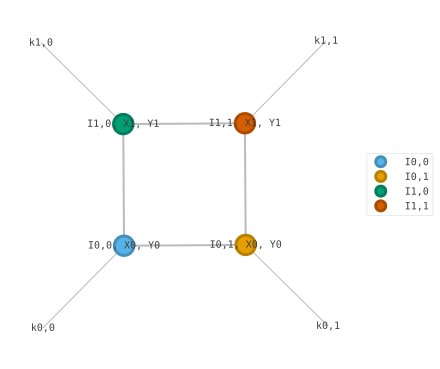

In [42]:
tn.draw(color=['I0,0', 'I0,1', 'I1,0', 'I1,1'])

However it doesn't have any of the special {class}`~quimb.tensor.tensor_2d.PEPS`
methods yet. Rather than retrieving raw arrays and calling `PEPS(arrays)`,
we can use the following functions to directly instantiate a PEPS:

:::{note}
Note the following only work because **we have already correctly tagged and
labelled the tensors**, thus 'promising' that the PEPS structure exists.
:::

### `from_TN`

In [43]:
# we need to tell the constructor what values we are using for the following:
qtn.PEPS._EXTRA_PROPS

('_site_tag_id', '_x_tag_id', '_y_tag_id', '_Lx', '_Ly', '_site_ind_id')

In [44]:
peps = qtn.PEPS.from_TN(
    tn, 
    Lx=2, 
    Ly=2,
    site_tag_id='I{},{}', 
    site_ind_id='k{},{}',
    x_tag_id='X{}',
    y_tag_id='Y{}',
)
peps

<PEPS(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [45]:
peps.show()

    4   
 ●━━━━●
╱┃4  ╱┃4  
 ┃  4 ┃ 
 ●━━━━●
╱    ╱    


### `TensorNetwork.view_as`

We can also use the method version,
[`TensorNetwork.view_as`](quimb.tensor.tensor_core.TensorNetwork.view_as),
which enables an inplace option:

In [48]:
tn.view_as_(
    qtn.tensor_2d.TensorNetwork2DFlat,
    Lx=2, 
    Ly=2,
    site_tag_id='I{},{}',
    x_tag_id='X{}',
    y_tag_id='Y{}',
)

<TensorNetwork2DFlat(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [49]:
# `tn` is now a 'FLat 2D TN'
tn.show()

    4   
 ●━━━━●
 ┃4   ┃4  
 ┃  4 ┃ 
 ●━━━━●
          


### `TensorNetwork.view_like`

Finally, and often most conveniently, if you have an
existing structured TN with extra attributes you want to match,
you can call
[`TensorNetwork.view_like`]quimb.tensor.tensor_core.TensorNetwork.view_like), which
defaults to picking up all the necessary attributes from whatever
you supply to the `like=` kwarg:

In [50]:
other_peps = qtn.PEPS.rand(Lx=2, Ly=2, bond_dim=5)

tn.view_like_(other_peps)

<PEPS(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [51]:
# `tn` is now a PEPS with its special methods
tn.expand_bond_dimension(9).show()

    9   
 ●━━━━●
╱┃9  ╱┃9  
 ┃  9 ┃ 
 ●━━━━●
╱    ╱    


This is useful if you perform modifications to a specific type of TN,
such that it loses its structured identity, but then you want to recast
it as original type, knowing that all the tags and indices are still correct.

### Compatible Subclasses

One final feature to note regarding specific tensor network
subclasses is that when you combine certain TNs with the
`&` or `|` operators, if they are both 'compatible' versions
of an inherited structured TN, they keep that structure:

In [52]:
# so if we combine two MPS, which are both TensorNetwork1D
mps_a = qtn.MPS_rand_state(10, 7)
mps_b = qtn.MPS_rand_state(10, 7)

# we get a TensorNetwork1D
mps_a | mps_b

<TensorNetwork1D(tensors=20, indices=28, L=10, max_bond=7)>

In [53]:
# and if we combine two PEPS, which are both TensorNetwork2D
peps_a = qtn.PEPS.rand(10, 10, 7)
peps_b = qtn.PEPS.rand(10, 10, 7)

# we get a TensorNetwork2D
peps_a | peps_b

<TensorNetwork2D(tensors=200, indices=460, Lx=10, Ly=10, max_bond=7)>

One key thing this allows is for structured contraction schemes
to remain avaiable once norm- or expectation- TNs have been formed
for example, without calling
{meth}`~quimb.tensor.tensor_core.TensorNetwork.view_like`.

## Standard vs. Hyper Indices & Tensor Networks

- In standard summation expressions and tensor networks, if an index appears
  twice it is contracted, and if it appears once, it is an 'outer' index that
  will be retained. Such a setup is assumed to be the default when contracting
  tensors, and an error will be raised if an index is encountered more than
  twice.
- On the other hand, it is a perfectly valid 'sum-of-products-of-tensor-entries'
  expression to have indices appear an arbitrary number of times.
  It can be very beneficial to do so in fact. `quimb`
  supports this, with the main difference being that you will have to
  explicitly name the `output_inds` for contractions, which can no
  longer be automatically inferred.

In [54]:
T1 = qtn.rand_tensor((2, 2), ('a', 'x'))
T2 = qtn.rand_tensor((2, 2), ('b', 'x'))
T3 = qtn.rand_tensor((2, 2), ('c', 'x'))

# we'll get an error due to 'x' unless we specify output_inds
qtn.tensor_contract(T1, T2, T3, output_inds=['a', 'b', 'c'])

Tensor(shape=(2, 2, 2), inds=('a', 'b', 'c'), tags=oset([]))

The above has performed the summation:

$$
T[a, b, c] = \sum_{x}  T_1[a, x] T_2[b, x] T_2[c, x]
$$

I.e. everything that doesn't appear in the `output_inds` is
summed over and removed. Indices such as 'x' can be thought
of as hyperedges:

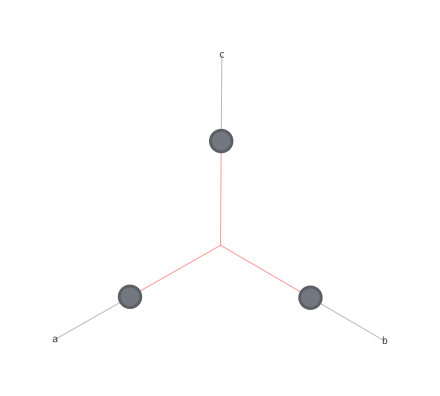

In [55]:
(T1 | T2 | T3).draw(highlight_inds=['x'])

:::{note}
Contractions of 'standard' tensor networks can be performed just using
pairwise 'matrix-multiplication equivalent' contractions,
i.e. using {func}`~numpy.tensordot`. While 'hyper' tensor networks
are still contracted using pairwise operations, these might require
routines equivalent to 'batched-matrix-multiplication' and so
{func}`~numpy.einsum`.
:::